# 7.4 含并行连结的网络（GoogLeNet）

GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。 这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。 毕竟，以前流行的网络使用小到1 * 1，大11 * 11到的卷积核。 本文的一个观点是，有时使用不同大小的卷积核组合是有利的。 在本节中，我们将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，现在有了更好的训练方法，这些特性不是必要的。

## 7.4.1 Inception块

在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

Inception块由四条并行路径组成。前三条路径使用窗口大小为1 * 1、3 * 3和5 * 5的卷积层，从不同空间大小中提取信息。中间两条路径在输入上执行1 * 1卷积，以减少通道，从而降低模型的复杂性。第四条通道使用3 * 3最大汇聚层，然后使用1 * 1卷积层来改变通道数。这四条路径都使用合适的填充来使输入和输出的高和宽一致。最后，我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1 * 1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1 * 1卷积层后接3 * 3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1 * 1卷积层后接5 * 5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 * 3最大汇聚层后接1 * 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(F.relu(self.p4_1(x))))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

那么为什么GoogLeNet这个网络如此有效呢？ 首先我们考虑一下滤波器（filter）的组合，它们可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。 同时，我们可以为不同的滤波器分配不同数量的参数。

## 7.4.2 GoogLeNet模型

GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。 第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

现在，我们逐一实现GoogLeNet的每个模块。第一个模块使用64个通道，7 * 7卷积层。

In [2]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第二个模块使用两个卷积层：第一个卷积层是64个通道、1 * 1卷积层；第二个卷积层使用将通道数量增加三倍的3 * 3卷积层。这对应于Inception块中的第二条路径。

In [3]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                  nn.ReLU(),
                  nn.Conv2d(64, 192, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第三个模块串联两个完整的Inception块。

In [4]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                  Inception(256, 128, (128, 192), (32, 96), 64),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第四模块串联了5个Inception块。

In [5]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                  Inception(512, 160, (112, 224), (24, 64), 64),
                  Inception(512, 128, (128, 256), (24, 64), 64),
                  Inception(512, 112, (144, 288), (32, 64), 64),
                  Inception(528, 256, (160, 320), (32, 128), 128),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五个模块包含两个Inception块。

In [6]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                  Inception(832, 384, (192, 384), (48, 128), 128),
                  nn.AdaptiveAvgPool2d((1, 1)),
                  nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。 为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96，这简化了计算。下面演示各个模块输出的形状变化。

In [7]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## 7.4.3 训练模型

和以前一样，我们使用Fashion-MNIST数据集来训练我们的模型。在训练之前，我们将图片转换为96 * 96分辨率。

loss 0.236, train acc 0.910, test acc 0.898
4321.3 examples/sec on cuda:0


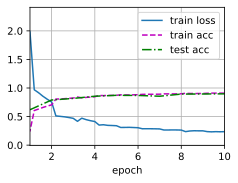

In [8]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 7.4.4 小结

· Inception块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大汇聚层来并行抽取信息，并使用1 * 1卷积层减少每像素级别上的通道维数，从而降低模型复杂度。  
· GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在ImageNet数据集上通过大量的实验得来的。  
· GoogLeNet和它的后继者们一度是ImageNet上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。